Step 1: Setup and Data Loading

This code will:

Import pandas, numpy, and matplotlib.
Load the dataset directly from its URL.
Clean up the column names for easier use.
Display the first 5 rows and the data types of each column.

In [8]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the dataset directly from the UCI repository URL
# We use header=1 to skip the first row which contains descriptive text
url = os.path.join('UCI_Credit_Card.csv')
df = pd.read_csv(url)

# Clean up column names (remove spaces and make them consistent)
df.rename(columns={'default.payment.next.month': 'DEFAULT'}, inplace=True)

# Display the first 5 rows to understand the data
print("First 5 rows of the dataset:")
print(df.head())

print("\n" + "="*50 + "\n")



First 5 rows of the dataset:
   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1    20000.0    2          2         1   24      2      2     -1     -1   
1   2   120000.0    2          2         2   26     -1      2      0      0   
2   3    90000.0    2          2         2   34      0      0      0      0   
3   4    50000.0    2          2         1   37      0      0      0      0   
4   5    50000.0    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...        0.0        0.0        0.0       0.0     689.0       0.0   
1  ...     3272.0     3455.0     3261.0       0.0    1000.0    1000.0   
2  ...    14331.0    14948.0    15549.0    1518.0    1500.0    1000.0   
3  ...    28314.0    28959.0    29547.0    2000.0    2019.0    1200.0   
4  ...    20940.0    19146.0    19131.0    2000.0   36681.0   10000.0   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  DEFAULT  
0       0.0   

In [9]:
# Display dataset information (columns, data types, non-null counts)
print("Dataset Information:")
df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         30000 non-null  int64  
 1   LIMIT_BAL  30000 non-null  float64
 2   SEX        30000 non-null  int64  
 3   EDUCATION  30000 non-null  int64  
 4   MARRIAGE   30000 non-null  int64  
 5   AGE        30000 non-null  int64  
 6   PAY_0      30000 non-null  int64  
 7   PAY_2      30000 non-null  int64  
 8   PAY_3      30000 non-null  int64  
 9   PAY_4      30000 non-null  int64  
 10  PAY_5      30000 non-null  int64  
 11  PAY_6      30000 non-null  int64  
 12  BILL_AMT1  30000 non-null  float64
 13  BILL_AMT2  30000 non-null  float64
 14  BILL_AMT3  30000 non-null  float64
 15  BILL_AMT4  30000 non-null  float64
 16  BILL_AMT5  30000 non-null  float64
 17  BILL_AMT6  30000 non-null  float64
 18  PAY_AMT1   30000 non-null  float64
 19  PAY_AMT2   30000 non-null

Step 2: Target Variable Engineering

This is the most important step where we reframe the business problem. Instead of predicting DEFAULT, we will create a new target variable called limit_decision with three categories: Increase, Maintain, and Decrease.

This code will:\
Define a function that implements our business logic.\
Apply this function to the DataFrame to create our new target column.\
Show the distribution of the new categories.



Distribution of the new 'limit_decision' target variable:
limit_decision
Maintain    14934
Increase     8430
Decrease     6636
Name: count, dtype: int64


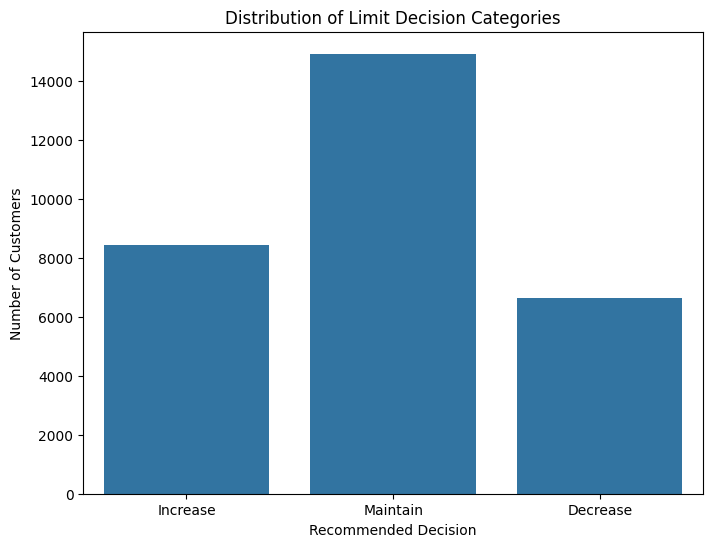

In [10]:
# Define the logic for our new target variable
def assign_limit_decision(row):
    # Rule 1: Decrease Limit (Category 0)
    # If the customer defaulted, their limit should be reviewed for a decrease.
    if row['DEFAULT'] == 1:
        return 'Decrease'

    # Rule 2: Increase Limit (Category 2)
    # Conditions: Did not default, no payment delays in the last 2 months,
    # and their average bill is at least 40% of their credit limit.
    elif (row['PAY_0'] <= 0 and row['PAY_2'] <= 0 and
          (row[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3']].mean() / row['LIMIT_BAL']) > 0.4):
        return 'Increase'

    # Rule 3: Maintain Limit (Category 1)
    # All other non-defaulting customers.
    else:
        return 'Maintain'

# Apply the function to create the new target column
df['limit_decision'] = df.apply(assign_limit_decision, axis=1)

print("\n" + "="*50 + "\n")

# Check the distribution of our new target variable
print("Distribution of the new 'limit_decision' target variable:")
print(df['limit_decision'].value_counts())

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='limit_decision', data=df, order=['Increase', 'Maintain', 'Decrease'])
plt.title('Distribution of Limit Decision Categories')
plt.xlabel('Recommended Decision')
plt.ylabel('Number of Customers')
plt.show()

In this step, we will:

Create new, more powerful features from the existing data to capture customer behavior over time.

Drop columns that are no longer needed.\
Separate our data into features (X) and the target (y).\
Define the preprocessing steps for numerical and categorical data using scikit-learn's ColumnTransformer, which is a robust method you used in your previous project.\


**Step 3: Feature Engineering & Preprocessing Pipeline**\
Here's the code to create new features and prepare the data for modeling.

In [35]:
# Import preprocessing tools from sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
# --- Feature Engineering ---

# 1. Average Credit Utilization (as a percentage of the limit)
# We will calculate this over the last 3 months for recent behavior
# Replace 0s in LIMIT_BAL to avoid division by zero, though this dataset shouldn't have them
df['AVG_UTILIZATION_3M'] = df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3']].mean(axis=1) / df['LIMIT_BAL']

# 2. Average Payment Ratio (how much of the bill they paid)
# We calculate this for the last 3 months. We add a small epsilon to avoid division by zero.
epsilon = 1e-6
df['AVG_PAY_RATIO_3M'] = df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3']].mean(axis=1) / (df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3']].mean(axis=1) + epsilon)

# 3. Number of late payments in the last 6 months
pay_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
df['LATE_PAYMENT_COUNT'] = (df[pay_cols] > 0).sum(axis=1)

In [13]:
# --- Data Preparation ---

# Drop the original ID and DEFAULT columns, as they are no longer needed for modeling
df_model = df.drop(['ID', 'DEFAULT'], axis=1)

# Separate features (X) and our new target variable (y)
X = df_model.drop('limit_decision', axis=1)
y = df_model['limit_decision']

# Encode the categorical target variable 'limit_decision' into numbers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# We can see the mapping
print("Label Encoder Mapping:")
print(dict(zip(le.classes_, le.transform(le.classes_))))
print("\n" + "="*50 + "\n")

Label Encoder Mapping:
{'Decrease': 0, 'Increase': 1, 'Maintain': 2}




In [14]:
# --- Preprocessing Pipeline Setup ---

# Identify categorical and numerical columns for the preprocessor
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=np.number).columns

# Create the preprocessing pipelines for numerical and categorical features
# This is similar to your original notebook's structure
numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Create the column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ],
    remainder='passthrough' # This ensures no columns are accidentally dropped
)


# Display the features we've prepared for the model
print("Final features used for the model:")
print(X.columns.tolist())
print("\nShape of feature matrix X:", X.shape)
print("Shape of target vector y:", y_encoded.shape)

Final features used for the model:
['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'AVG_UTILIZATION_3M', 'AVG_PAY_RATIO_3M', 'LATE_PAYMENT_COUNT']

Shape of feature matrix X: (30000, 26)
Shape of target vector y: (30000,)


Step 3 (Revised): Feature Engineering & Statistical Feature Selection


This revised code block will:

Perform the feature engineering as before.\
Chi-Square Test: Test the relationship between categorical features and our limit_decision target.\
ANOVA F-test: Test the relationship between numerical features and the target.\
VIF (Variance Inflation Factor): Check for and remove multicollinearity among the remaining numerical features.\
Finally, we will have our definitive list of features to use for modeling.

In [15]:
from scipy.stats import chi2_contingency, f_oneway
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [16]:
# --- Feature Engineering (from previous step) ---

# 1. Average Credit Utilization (as a percentage of the limit)
df['AVG_UTILIZATION_3M'] = df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3']].mean(axis=1) / df['LIMIT_BAL']

# 2. Average Payment Ratio (how much of the bill they paid)
epsilon = 1e-6
df['AVG_PAY_RATIO_3M'] = df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3']].mean(axis=1) / (df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3']].mean(axis=1) + epsilon)

# 3. Number of late payments in the last 6 months
pay_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
df['LATE_PAYMENT_COUNT'] = (df[pay_cols] > 0).sum(axis=1)

In [17]:
# --- Statistical Feature Selection ---

print("--- Starting Feature Selection ---")
# Define feature lists
all_cat_features = ['SEX', 'EDUCATION', 'MARRIAGE']
# We include our newly engineered features in the numerical list
all_num_features = ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
                    'AVG_UTILIZATION_3M', 'AVG_PAY_RATIO_3M', 'LATE_PAYMENT_COUNT']

--- Starting Feature Selection ---


In [18]:
# --- Part A: Chi-Square Test for Categorical Features ---
print("\n1. Chi-Square Test Results (p-value <= 0.05 is significant):")
categorical_features_to_keep = []
for feature in all_cat_features:
    contingency_table = pd.crosstab(df[feature], df['limit_decision'])
    chi2, pval, _, _ = chi2_contingency(contingency_table)
    print(f"{feature}: p-value = {pval:.4f}")
    if pval <= 0.05:
        categorical_features_to_keep.append(feature)
print(f"\nCategorical features kept: {categorical_features_to_keep}")


1. Chi-Square Test Results (p-value <= 0.05 is significant):
SEX: p-value = 0.0000
EDUCATION: p-value = 0.0000
MARRIAGE: p-value = 0.0000

Categorical features kept: ['SEX', 'EDUCATION', 'MARRIAGE']


In [19]:
# --- Part B: ANOVA F-test for Numerical Features ---
print("\n2. ANOVA F-test Results (p-value <= 0.05 is significant):")
numerical_features_to_keep_after_anova = []
for feature in all_num_features:
    groups = df.groupby('limit_decision')[feature].apply(list)
    f_stat, p_value = f_oneway(*groups)
    #print(f"{feature}: p-value = {p_value:.4f}") # Uncomment to see all p-values
    if p_value <= 0.05:
        numerical_features_to_keep_after_anova.append(feature)
print(f"\nNumerical features kept after ANOVA: {len(numerical_features_to_keep_after_anova)} out of {len(all_num_features)}")


2. ANOVA F-test Results (p-value <= 0.05 is significant):

Numerical features kept after ANOVA: 23 out of 23


In [20]:
# --- Part C: VIF for Multicollinearity ---
print("\n3. Iterative VIF Calculation (removing features with VIF > 6):")
vif_data = df[numerical_features_to_keep_after_anova]
total_cols = vif_data.shape[1]

# This is the iterative process from your original notebook
while True:
    vif_values = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]
    max_vif = max(vif_values)
    
    if max_vif > 6:
        max_vif_index = vif_values.index(max_vif)
        removed_feature = vif_data.columns[max_vif_index]
        vif_data = vif_data.drop(columns=[removed_feature])
        print(f"  - Removed '{removed_feature}' (VIF: {max_vif:.2f})")
    else:
        break

final_numerical_cols = vif_data.columns.tolist()
print(f"\nFinal numerical features after VIF: {final_numerical_cols}")

print("\n--- Feature Selection Complete ---")


3. Iterative VIF Calculation (removing features with VIF > 6):
  - Removed 'BILL_AMT2' (VIF: 38.51)
  - Removed 'BILL_AMT5' (VIF: 36.00)
  - Removed 'BILL_AMT3' (VIF: 24.81)
  - Removed 'BILL_AMT4' (VIF: 15.35)
  - Removed 'AGE' (VIF: 7.21)

Final numerical features after VIF: ['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'AVG_UTILIZATION_3M', 'AVG_PAY_RATIO_3M', 'LATE_PAYMENT_COUNT']

--- Feature Selection Complete ---


Step 4: Final Preprocessing and Data Splitting

Now, we will take our final feature lists, build the preprocessing pipeline, and split the data into training and testing sets. This will be the last step before we start training the models.

In [21]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

In [22]:
# --- Final Feature Lists (from our selection process) ---
final_categorical_cols = ['SEX', 'EDUCATION', 'MARRIAGE']
final_numerical_cols = ['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
                        'BILL_AMT1', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 
                        'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'AVG_UTILIZATION_3M', 
                        'AVG_PAY_RATIO_3M', 'LATE_PAYMENT_COUNT']

final_features = final_numerical_cols + final_categorical_cols

In [23]:
# --- Data Preparation using Final Features ---

# Create our final feature matrix X and target vector y
X = df[final_features]
y = df['limit_decision']

# Encode the categorical target variable 'limit_decision' into numbers (0, 1, 2)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [24]:
# --- Preprocessing Pipeline Setup ---

# We define the pipelines using our final lists of columns
numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Create the final column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, final_numerical_cols),
        ('cat', categorical_pipeline, final_categorical_cols)
    ],
    remainder='passthrough'
)

In [25]:
# --- Train-Test Split ---
# We split the data BEFORE applying the preprocessor
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# --- Apply Preprocessing ---
# Fit the preprocessor on the training data and transform both train and test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("--- Data Splitting and Processing Complete ---")
print("Shape of X_train_processed:", X_train_processed.shape)
print("Shape of X_test_processed:", X_test_processed.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

--- Data Splitting and Processing Complete ---
Shape of X_train_processed: (24000, 28)
Shape of X_test_processed: (6000, 28)
Shape of y_train: (24000,)
Shape of y_test: (6000,)


**Step 5: Model Training, Evaluation, and Hyperparameter Tuning**


This code block will:

Define a dictionary of models to evaluate: LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, and XGBClassifier.\
Loop through each model, train it, and print a detailed classification report.\
Set up a parameter grid for GridSearchCV to tune the XGBClassifier.\
Run the grid search to find the best combination of hyperparameters.\
Evaluate the final, tuned XGBoost model and display its performance with a classification report and a confusion matrix.

In [30]:
# Import models and evaluation metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [32]:
# --- Part A: Baseline Model Evaluation (Expanded) ---

# Define the models we want to evaluate, now including AdaBoost and SVC
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Support Vector Machine": SVC(random_state=42), # Note: This can be slow on this dataset size
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
}

# Remember the label mapping: 0: Decrease, 1: Increase, 2: Maintain
target_names = ['Decrease', 'Increase', 'Maintain'] 

print("--- Starting Baseline Model Evaluation ---")

for name, model in models.items():
    # Train the model
    print(f"Training {name}...")
    model.fit(X_train_processed, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test_processed)
    
    # Evaluate and print the results
    print(f"\n----- {name} -----")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))
    print("="*60)

print("\n--- Baseline Evaluation Complete ---")

--- Starting Baseline Model Evaluation ---
Training Logistic Regression...

----- Logistic Regression -----
Accuracy: 0.7773
Classification Report:
              precision    recall  f1-score   support

    Decrease       0.58      0.35      0.44      1327
    Increase       0.85      0.91      0.88      1686
    Maintain       0.79      0.89      0.84      2987

    accuracy                           0.78      6000
   macro avg       0.74      0.72      0.72      6000
weighted avg       0.76      0.78      0.76      6000

Training Decision Tree...

----- Decision Tree -----
Accuracy: 0.7145
Classification Report:
              precision    recall  f1-score   support

    Decrease       0.37      0.41      0.39      1327
    Increase       0.87      0.84      0.86      1686
    Maintain       0.80      0.78      0.79      2987

    accuracy                           0.71      6000
   macro avg       0.68      0.68      0.68      6000
weighted avg       0.73      0.71      0.72      600

C:\Users\abhis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [23:26:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



----- XGBoost -----
Accuracy: 0.8120
Classification Report:
              precision    recall  f1-score   support

    Decrease       0.63      0.37      0.46      1327
    Increase       0.87      0.99      0.92      1686
    Maintain       0.82      0.91      0.86      2987

    accuracy                           0.81      6000
   macro avg       0.77      0.76      0.75      6000
weighted avg       0.79      0.81      0.79      6000


--- Baseline Evaluation Complete ---


In [33]:
# --- Part B: Hyperparameter Tuning with GridSearchCV for XGBoost ---
# This part remains the same, focusing on our best-performing model candidate

print("\n--- Starting Hyperparameter Tuning for XGBoost ---")

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.2],
    'min_child_weight': [1, 3]
}

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, 
                           scoring='accuracy', cv=3, verbose=2, n_jobs=-1)

grid_search.fit(X_train_processed, y_train)

print("\n--- Hyperparameter Tuning Complete ---")
print(f"\nBest Parameters Found: {grid_search.best_params_}")
print(f"Best Cross-validation Accuracy: {grid_search.best_score_:.4f}")


--- Starting Hyperparameter Tuning for XGBoost ---
Fitting 3 folds for each of 16 candidates, totalling 48 fits


C:\Users\abhis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [23:27:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Hyperparameter Tuning Complete ---

Best Parameters Found: {'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
Best Cross-validation Accuracy: 0.8206



--- Evaluating the Final Tuned XGBoost Model ---

Tuned XGBoost Accuracy: 0.8212
Tuned XGBoost Classification Report:
              precision    recall  f1-score   support

    Decrease       0.67      0.37      0.48      1327
    Increase       0.86      1.00      0.93      1686
    Maintain       0.83      0.92      0.87      2987

    accuracy                           0.82      6000
   macro avg       0.79      0.76      0.76      6000
weighted avg       0.80      0.82      0.80      6000



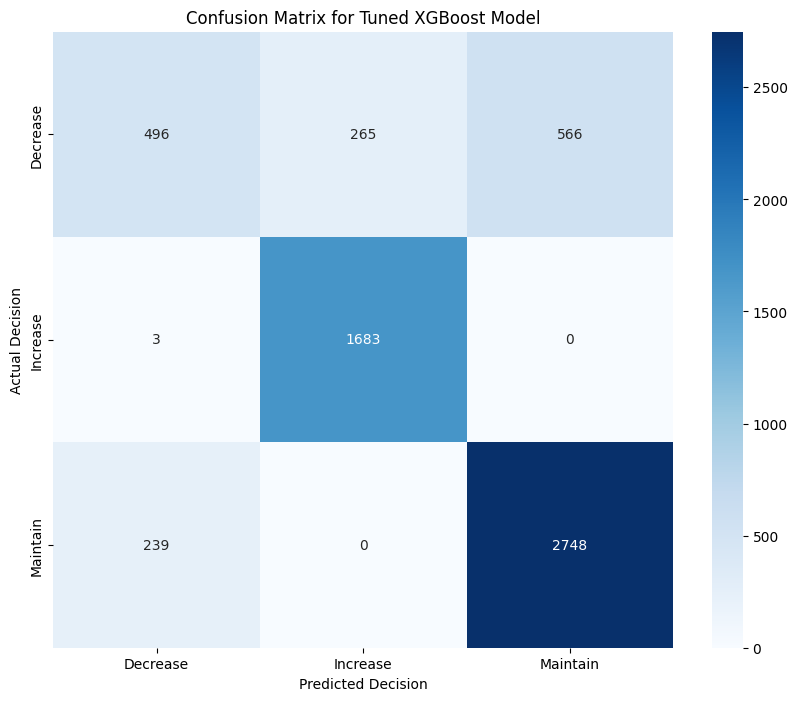

In [34]:
# --- Part C: Final Evaluation of the Tuned Model ---

print("\n--- Evaluating the Final Tuned XGBoost Model ---")

best_xgb = grid_search.best_estimator_
y_pred_tuned = best_xgb.predict(X_test_processed)

print(f"\nTuned XGBoost Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}")
print("Tuned XGBoost Classification Report:")
print(classification_report(y_test, y_pred_tuned, target_names=target_names))

# Visualize the final results with a Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix for Tuned XGBoost Model')
plt.xlabel('Predicted Decision')
plt.ylabel('Actual Decision')
plt.show()

**Summary of This Step:**

Baseline Performance: The first part of the code gives you a clear comparison of how different algorithms handle this specific problem. You will likely see that the ensemble methods (RandomForest and XGBoost) perform best.

Optimization: The GridSearchCV part is computationally intensive but crucial. It systematically searches for the hyperparameter combination that yields the best performance, saving you from manual trial-and-error.

Final Results: The final classification report and confusion matrix will show you the real-world performance of your tuned model. You'll be able to see exactly how well it predicts "Increase," "Maintain," and "Decrease" and where it might be getting confused.

After running this, we will have a fully trained and evaluated model for the Dynamic Credit Limit Optimization project.